# Tarea 9: Dask

## Elizabeth Solis Díaz 


Aprovecha la capacidad de Dask para realizar cómputo en paralelo para ajustar un modelo para predecir la proporción de propina de un viaje. Realiza búsqueda de hiperparámetros en grid con cross validation. Puedes usar funciones de scikit learn. Recuerda usar el decorador delayed para ejecutar en paralelo.

+ ¿Qué tan rápido es buscar en paralelo comparado con una búsqueda secuencial en python?

Haz lo mismo que arriba, pero utilizando la biblioteca Dask-ML http://dask-ml.readthedocs.io/en/latest/

+ ¿Cómo se comparan los tiempos de ejecución de tu búsqueda con la de Dask ML?

In [3]:
# Lectura datos
import pandas as pd
from sklearn import linear_model
from sklearn.pipeline import Pipeline

trips_df = pd.read_csv("/data/trips.csv", encoding='utf-8')
trips_df.head()

,car_type,fare_amount,passenger_count,taxi_id,tip_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance
0,A,22.0,1,1,4.60,2015-01-03 01:37:02,2015-01-03 01:17:32,6.90
1,A,9.0,1,1,0.00,2015-01-05 23:35:02,2015-01-05 23:25:15,1.81
2,A,7.5,1,1,1.00,2015-01-06 15:22:12,2015-01-06 15:11:45,0.96
3,A,8.5,1,1,1.00,2015-01-08 08:31:23,2015-01-08 08:22:12,1.90
4,A,7.5,1,1,1.66,2015-01-08 12:35:54,2015-01-08 12:26:26,1.00


## Obtengamos estadisticos descriptivos relevantes de la variable propina


In [5]:
# Obtengamos estadisticos descriptivos relevantes de la variable propina
trips_df.tip_amount.describe()

count    9198.000000
mean        1.540099
std         2.180261
min        -0.700000
25%         0.000000
50%         1.050000
75%         2.100000
max        40.000000
Name: tip_amount, dtype: float64

# Supuesto
La manera en la cual obtendremos la propina será:


    tip_amount/(tip_amount + fare_amount)

In [6]:
# Truco para convertir a datetime...
trips_df.tpep_pickup_datetime = trips_df.tpep_pickup_datetime.astype('M8[us]')
trips_df.tpep_dropoff_datetime = trips_df.tpep_dropoff_datetime.astype('M8[us]')

# Agrega una columna para la duración del viaje
trips_df["trip_duration"] = trips_df.tpep_dropoff_datetime - trips_df.tpep_pickup_datetime

# Agrega una columna para el porcentaje de propina 
import numpy as np
# Matriz X
pdX = trips_df[["car_type","fare_amount", "passenger_count", "trip_distance", "total_fee"]]
# Variable Respuesta


pdxcartypeDummies = pd.get_dummies(pdX["car_type"])
pdX = pd.concat([pdX,pdxcartypeDummies], axis=1)
pdX.drop('car_type', axis=1, inplace=True)
pdX['A'] = pdX.A.astype(int)
pdX['B'] = pdX.B.astype(int)
pdX.fillna(0, inplace=True)

pdy = trips_df[["tip_percentage"]]
pdy = pdy.replace([np.inf, -np.inf], 1)
pdy.fillna(0, inplace=True)["total_fee"] = trips_df.tip_amount + trips_df.fare_amount 
trips_df["tip_percentage"] = trips_df.tip_amount.div(trips_df.total_fee)
trips_df.head()

,car_type,fare_amount,passenger_count,taxi_id,tip_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,trip_duration,total_fee,tip_percentage
0,A,22.0,1,1,4.60,2015-01-03 01:37:02,2015-01-03 01:17:32,6.90,00:19:30,26.60,0.172932
1,A,9.0,1,1,0.00,2015-01-05 23:35:02,2015-01-05 23:25:15,1.81,00:09:47,9.00,0.000000
2,A,7.5,1,1,1.00,2015-01-06 15:22:12,2015-01-06 15:11:45,0.96,00:10:27,8.50,0.117647
3,A,8.5,1,1,1.00,2015-01-08 08:31:23,2015-01-08 08:22:12,1.90,00:09:11,9.50,0.105263
4,A,7.5,1,1,1.66,2015-01-08 12:35:54,2015-01-08 12:26:26,1.00,00:09:28,9.16,0.181223


In [8]:
import numpy as np
# Matriz X
pdX = trips_df[["car_type","fare_amount", "passenger_count", "trip_distance", "total_fee"]]

# Creamos variables dummies para el car type
pdxcartypeDummies = pd.get_dummies(pdX["car_type"])
pdX = pd.concat([pdX,pdxcartypeDummies], axis=1)
pdX.drop('car_type', axis=1, inplace=True)
pdX['A'] = pdX.A.astype(int)
pdX['B'] = pdX.B.astype(int)
pdX.fillna(0, inplace=True)
pdX.head()

,fare_amount,passenger_count,trip_distance,total_fee,A,B
0,22.0,1,6.90,26.60,1,0
1,9.0,1,1.81,9.00,1,0
2,7.5,1,0.96,8.50,1,0
3,8.5,1,1.90,9.50,1,0
4,7.5,1,1.00,9.16,1,0


In [17]:
# Variable Respuesta
pdy = trips_df[["tip_percentage"]]
pdy = pdy.replace([np.inf, -np.inf], 0)
pdy.fillna(0, inplace=True)
pdy.head()

,tip_percentage
0,0.172932
1,0.000000
2,0.117647
3,0.105263
4,0.181223


# Scikit estimator

In [79]:
# Declaramos el modelo de regresión lineal que utilizaremos
linear = linear_model.LinearRegression()
pipelinear = Pipeline(steps=[('linear', linear)])
gridlinear = dict(linear__n_jobs=[1,2,3,4,5], linear__fit_intercept=[True, False], linear__normalize=[False,True])

## Secuencial

In [80]:
# Realizamos la búsqueda de hiperparámetros en grid con cross validation
from sklearn.grid_search import GridSearchCV
estimator1 = GridSearchCV(pipelinear, gridlinear, n_jobs= 4)

### Tiempo de ejecución en secuencial con scickit learn:

In [81]:
%%time
tiempo_secuencial_ejec = estimator1.fit(pdX, pdy["tip_percentage"])

CPU times: user 130 ms, sys: 60 ms, total: 190 ms
Wall time: 404 ms


### Mejores parametros del modelo:

In [82]:
print(estimator1.best_params_)


{'linear__normalize': True, 'linear__n_jobs': 1, 'linear__fit_intercept': True}


### Métricas del mejor modelo

In [83]:
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error

y_pred = estimator1.predict(pdX)
print("r2Score:",r2_score(pdy["tip_percentage"], y_pred))
print("ExplaindeVarianze",explained_variance_score(pdy["tip_percentage"], y_pred))
print("MS2:",mean_squared_error(pdy["tip_percentage"], y_pred))



r2Score: 0.5406372468883742
ExplaindeVarianze 0.540637246888374
MS2: 0.004021544603410263


## Paralelo

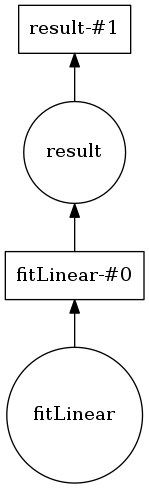

In [84]:
# Usamos el decorador delayed para ejecutar en paralelo.
from dask import delayed

# Mandamos a ejecutar el pipeline para buscar los hiperparametros y cross validation
@delayed
def fitLinear():
    return estimator1.fit(pdX, pdy["tip_percentage"])

# Guardamos el resultado
@delayed
def result( est1):
    return[est1]

result = result(fitLinear())
result.visualize()

### Tiempo de ejecución en paralelo con scickit learn:

In [85]:
%%time
result_computed = result.compute()

/usr/local/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


CPU times: user 320 ms, sys: 690 ms, total: 1.01 s
Wall time: 307 ms


### Mejores parametros del modelo:

In [86]:
for pipe in result_computed:
    print(pipe.best_params_)

{'linear__normalize': True, 'linear__n_jobs': 1, 'linear__fit_intercept': True}


### ¿Qué tan rápido es buscar en paralelo comparado con una búsqueda secuencial en python?

Resultó ser más rápido en paralelo como esperabamos; sin embargo, esto no ocurre si en el gridsearch asignamos njobs=1. Con el valor de njobs en el gridsearch que pusimos si se cumple que es más lento en secuencial y en general con njobs >1.


# Dask estimator

In [87]:
# Creamos data frames en formato Dask
import dask.dataframe as dd
ddfX = dd.from_pandas(pdX,npartitions=1)
ddfX.head()

,fare_amount,passenger_count,trip_distance,total_fee,A,B
0,22.0,1,6.90,26.60,1,0
1,9.0,1,1.81,9.00,1,0
2,7.5,1,0.96,8.50,1,0
3,8.5,1,1.90,9.50,1,0
4,7.5,1,1.00,9.16,1,0


In [88]:
ddfY = dd.from_pandas(pdy,npartitions=1)
ddfY.head()

,tip_percentage
0,0.172932
1,0.000000
2,0.117647
3,0.105263
4,0.181223


In [89]:
# Declaramos el modelo de regresión lineal que utilizaremos con Dask
from dask_searchcv import GridSearchCV as DGSCV
from sklearn.linear_model import LinearRegression as LR
#from dask_ml.linear_model import LinearRegression as LR
##dask models has problems in the last release and the Linear Model is the only one compatible

linear = LR()
gridlinear = dict(linear__n_jobs=[1,2,3,4,5], linear__fit_intercept=[True, False], linear__normalize=[False,True])

dask_estimator = DGSCV(pipelinear, gridlinear, n_jobs = 4)

### Tiempo de ejecución con Dask:

In [90]:
%%time
tiempo_dask_ejec = dask_estimator.fit(ddfX, ddfY)

CPU times: user 260 ms, sys: 890 ms, total: 1.15 s
Wall time: 381 ms


### Mejores parametros del modelo:

In [91]:
print(dask_estimator.best_params_)

{'linear__normalize': True, 'linear__n_jobs': 1, 'linear__fit_intercept': True}


### Métricas del mejor modelo

In [92]:
dask_y_pred = dask_estimator.predict(pdX)
print("r2Score:",r2_score(ddfY["tip_percentage"], dask_y_pred))
print("ExplaindeVarianze",explained_variance_score(ddfY["tip_percentage"], dask_y_pred))
print("MS2:",mean_squared_error(ddfY["tip_percentage"], dask_y_pred))

r2Score: 0.5406372468883742
ExplaindeVarianze 0.540637246888374
MS2: 0.004021544603410263


## Conclusión:

### ¿Cómo se comparan los tiempos de ejecución de tu búsqueda con la de Dask ML?
Con esto hemos notado que el tiempo de ejecución en paralelo es menor que el tiempo de ejecución en secuencial y además al utilizar Dask logramos paralelizar pandas y es más rápido que en secuencial; no obstante, en este caso el tiempo de ejecución en paralelo es ligeramente inferior que con Dask.